# Tutorial things for SKLearn, Numpy, Numba etc.

In [87]:
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks
import math
import numba as nb
from scipy.optimize import least_squares, curve_fit
cufflinks.go_offline()

def get_waveforms(*indices, source_data: pd.DataFrame = None, get_indices_map: bool = False):
    """Gets plottable waveforms dataframe. Indices may be start,stop for slicing, or list of indices"""
    if len(indices) == 1 and isinstance(indices[0], (list, int)):
        indices = [indices[0]] if isinstance(indices[0], int) else indices[0]
    elif len(indices) == 2:
        indices = range(indices[0],indices[1])
    else:
        raise ValueError("Invalid indices provided. May be start,stop args for slicing, or list of indices")
    data = {f"[{i}] {source_data.values[i][2]} dT, {source_data.values[i][1]}eV": source_data.values[i][3:] for i in indices}
    df = pd.DataFrame(data=data)
    if get_indices_map is True:
        return df, {j: list(data.keys())[i] for i,j in enumerate(indices)}
    return df

def parfunc(x: float, a: float, x_0: float):
    return a * (max(x - x_0, 0))**2

@nb.njit
def parfunc_arr(x: np.array, a: float, x_0: float):
    return np.array([a * (max(x_ - x_0, 0))**2 for x_ in x])

@nb.jit(forceobj=True)
def _fit_parabolas(df_arr: np.array, y_max: float, columns: list):
    """Takes array and y_max and returns fitted parabolas array"""
    # Create empty results array
    results = np.array([[0.0]*9]*len(df_arr[0]))
    
    # Fit parabola for each column
    for i,colname in enumerate(columns):
        y_data = df_arr[df_arr[:,i] <= y_max, i]
        # print(f"[{i}] '{wave_col}' y_data:", y_data) if print_output else None
        x_data = np.arange(0,len(y_data))
        
        # Parabola fit
        popt, pcov = curve_fit(parfunc_arr, x_data, y_data, bounds=([-3, -10], [3, 40]))
        # check_df = pd.DataFrame(data = {"data": part, "fit": parfunc_arr(x_data, *popt)})
        tot_var = (parfunc_arr(x_data, *popt) - y_data)**2
        results[i][0:2] = popt
        results[i][2] = len(y_data)
        results[i][3] = np.sum(tot_var)
        results[i][4] = np.sum(tot_var[int(popt[1]):])
        results[i][5] = np.sum(tot_var) / len(tot_var)
        results[i][6] = np.sum(tot_var[int(popt[1]):]) / len(tot_var[int(popt[1]):])
        results[i][7] = (160 - float([s[s.find("]")+1:s.find("dT")] for s in [colname.replace(" ","")]][0]))/4
        results[i][8] = parfunc(results[i][7], *popt)
        # print(f"[{i}] '{wave_col}' parameters:", results[i], "x0_cutoff_var", tot_var[int(popt[1])]) if print_output else None
    return results

def fit_parabolas(df: pd.DataFrame, y_max: float, **kwargs):
    """Fits parabola to each column in the dataframe up to y-value ``y_max``, returns parameter df"""
    max_col = kwargs.pop("force_max_col", 127)
    if kwargs:
        raise TypeError(f"fit_parabolas() got an unexpected keyword argument '{list(kwargs.keys())[0]}'")
    if len(df.columns) > max_col:
        raise ValueError(f"Up to {max_col} columns can be fitted with this function, exceeded this by {len(df.columns)-max_col}")
    if not isinstance(y_max, float) or not (0 < y_max <= 1):
        raise ValueError(f"y_max parameter must be a float between 0 and 1")

    # Create numpy array from df for fast processing and get the results
    results = _fit_parabolas(df.to_numpy(), y_max, list(df.columns))

    results_df = pd.DataFrame(data=results,
                              columns=["a","x0","x_cutoff","var","x0_cutoff_var","rel_var","rel_x0_cutoff_var","xT","yT_fit"],
                              index=[col[:col.find("]")+1] for col in df.columns])
    return results_df.astype({"x_cutoff": 'int32'})
    # fig2 = wave_df.iplot(asFigure=True)
    # fig2.add_vline(x=(160-float([s[s.find("]")+1:s.find("dT")] for s in [col_for_str(wave_df, str(waveform)).replace(" ","")]][0]))/4, line_color="orange")
    
    # col_for_str = lambda df, col: [c for c in df.columns if col in c][0]

def df_with_fits(df: pd.DataFrame, y_max: float, return_results: bool = False, **kwargs):
    """Fits parabola to each column in the dataframe up to y-value ``y_max``, returns df with fitted columns"""
    results_df = fit_parabolas(df, y_max, **kwargs)

    # Create new dataframe with empty fit columns
    new_df = pd.concat([df]+[pd.DataFrame(data={f"Fit {i}": [np.nan]*len(df)}) for i in results_df.index], axis=1)
    
    # Add found fit values to each existing fit column
    for i in results_df.index:
        new_df[f"Fit {i}"][:results_df["x_cutoff"][i]] = parfunc_arr(df.index.to_numpy(), results_df["a"][i], results_df["x0"][i])[:results_df["x_cutoff"][i]]
    
    if return_results:
        return new_df, results_df
    return new_df

def corr_trace(results_df: pd.DataFrame, drop_rows: list = [], c_min_max: tuple = (None, None)):
    return go.Scatter(x=results_df["a"].drop(drop_rows),
                      y=(results_df["xT"]-results_df["x0"]).drop(drop_rows),
                      mode='markers',
                      marker=dict(cmax=c_min_max[1] or results_df["rel_x0_cutoff_var"].max(),
                                  cmin=c_min_max[0] or results_df["rel_x0_cutoff_var"].min(),
                                  color=results_df["rel_x0_cutoff_var"],
                                  colorbar=dict(title="Parabolic<br>fit error"),
                                  colorscale="Viridis"),
                      customdata=results_df[["rel_x0_cutoff_var","x_cutoff","xT"]],
                      hovertemplate = '<i>%{text}</i><br>'+
                                      '<b>a</b>: %{x:.6f} <br>'+
                                      '<b>Tx - x0</b>: %{y}<br>'+
                                      '<b>Par. fit error</b>: %{customdata[0]:.8f}<br>'+
                                      '<b>(xT, x_cutoff)</b>: (%{customdata[1]}, %{customdata[2]:.2f})',
                      text = ['Waveform {}'.format(tracename) for tracename in results_df.index])
    
def corr_fig(results_df: pd.DataFrame, drop_rows: list = [], c_min_max: tuple = (0, 3e-5)):
    fig = go.Figure(data=corr_trace(results_df, drop_rows, c_min_max))
    fig.update_layout(title='Correlation of fitted parabola and gamma arrival time',
                      xaxis_title="a",
                      yaxis_title="xT - x0")
    return fig

data0 = pd.read_csv("C:/Users/lenovo/Downloads/20231110-Na22-d0-12-ML-Tz6-100ns-ecf-06.csv")
# data1 = pd.read_csv("C:/Users/lenovo/Downloads/ML_waveforms.csv")
# data2 = pd.read_csv("C:/Users/lenovo/Downloads/ML_waveforms-E_dt.csv")
# data3 = pd.read_csv("C:/Users/lenovo/Downloads/ML_waveforms-E_dt-allch.csv")

display_all = 0
if display_all:
    display(data0) # Ch, E, dT, s0 ... s127
    display(data1)
    display(data2)
    display(data3)

0.059694238404952915 0.019249915262777147


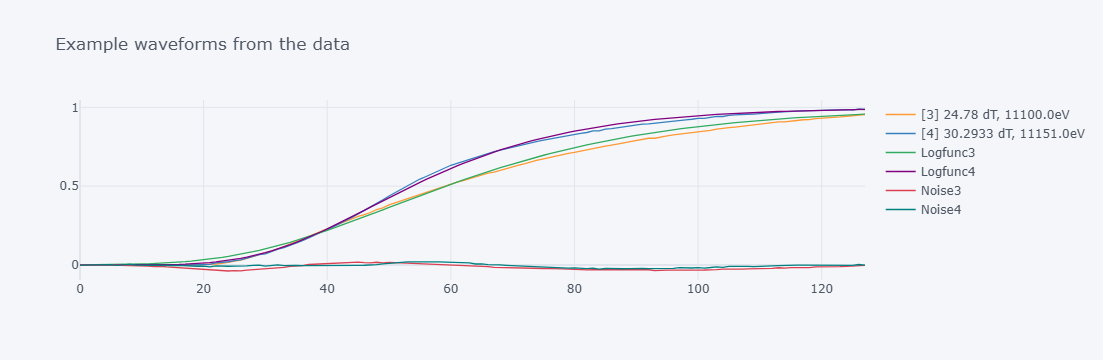

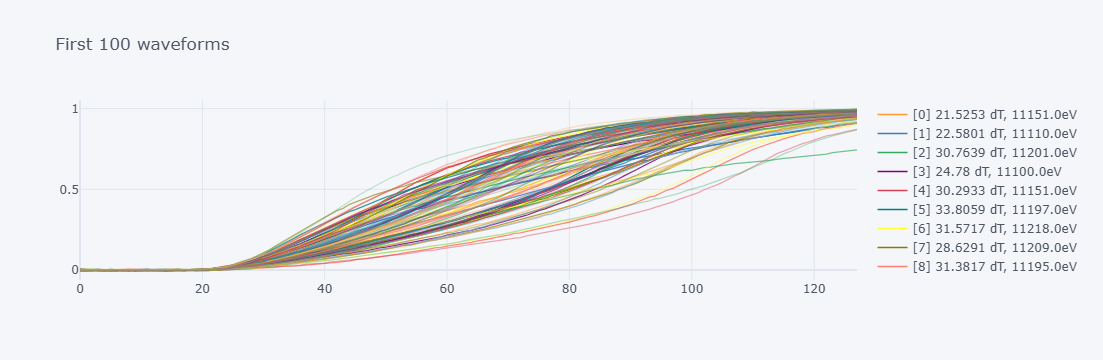

In [43]:
# Generalised logistic function
logfunc = lambda t, B, v, t_0: (1+np.exp(-B*(t-t_0)))**(-1/v)
logfunc_127 = lambda t, B, v, t_0: (1+np.exp(-B*(t/127-t_0)))**(-1/v)
t_0_shift = lambda B, v, xy_tup: xy_tup[0] + np.log(xy_tup[1]**(-v) - 1) / B
logfunc_xy = lambda t, B, v, xy_tup: (1+np.exp(-B*(t-t_0_shift(B, v, xy_tup))))**(-1/v)

col_for_str = lambda df, col: [c for c in df.columns if col in c][0]
# waveform = lambda df: {f"[{cn}]": df[col_for_colnum(df, cn)] for cn in range(len(df.columns))}
colcontains = lambda df, contains: df[col_for_str(df, contains)]
# t_0_shift = lambda B, v: 0.5 + math.log(0.5**(-v) - 1) / B

df = get_waveforms(3,5, source_data=data0)
#3
df["Logfunc3"] = [logfunc_xy(t/127, 5.2, 0.00001, (60/127,0.512045)) for t in range(0,128)]
# df["Logfunc3_0"] = [logfunc_xy(t/127, 5, 0.1, (60/127,0.512045)) for t in range(0,128)]
#4
df["Logfunc4"] = [logfunc_xy(t/127, 7, 0.001, (60/127,0.632591-0.02)) for t in range(0,128)]
# df["Logfunc4_0"] = [logfunc_xy(t/127, 7.2, 0.001, (60/127,0.632591-0.02)) for t in range(0,128)]
df["Noise3"] = colcontains(df, "[3]") - df["Logfunc3"]
df["Noise4"] =colcontains(df, "[4]") - df["Logfunc4"]
square_sum = lambda series: (series*series).sum()
print(square_sum(df["Noise3"]),square_sum(df["Noise4"]))
#[["Noise3", "Noise4"]]
df.iplot(title="Example waveforms from the data")
get_waveforms(0,100, source_data=data0).iplot(title="First 100 waveforms")

4 0.001 60 0.512045 timeshift 58.1727801046308
[ 4.93116070e+00  2.67731796e-03 -7.99999999e-01] [[9.81559651e-03 3.89007551e-03 2.97540500e-01]
 [3.89007551e-03 1.92668054e-03 1.47119405e-01]
 [2.97540500e-01 1.47119405e-01 1.12340196e+01]]
New fit: 0.038516006791716864 Original fit: 0.059694238404952915
New fit: 0.001533241824585574 Original fit: 0.0019087815926058832
33.805


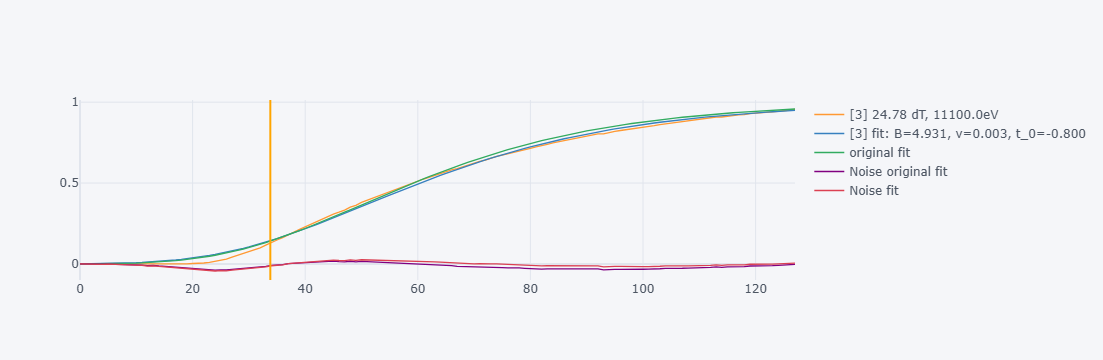

In [44]:
# Try finding regression parameters using SciPy model fit
from scipy.optimize import least_squares, curve_fit

x_data = np.arange(0,128)
waveform = [3]
wave_df, imap = get_waveforms(waveform, source_data=data0, get_indices_map=True)
y_data = wave_df[imap[waveform[0]]]
B0, v0, x0, y0 = 4, 0.001, 60, y_data[60]
print(B0, v0, x0, y0, "timeshift", t_0_shift(B0, v0, (x0, y0)))



# plt.plot(x_data, y_data, 'b-', label='data with noise')

popt, pcov = curve_fit(logfunc_127, x_data, y_data, bounds=([0., 0.0001, -0.8], [10., 1., 0.8]))
print(popt, pcov)

# plt.plot(x_data, func(x_data, *popt), 'g--',
#          label='fit: a=%5.3f, b=%5.3f, c=%5.7f' % tuple(popt))
wave_df[str(waveform)+' fit: B=%5.3f, v=%5.3f, t_0=%5.3f' % tuple(popt)] = logfunc_127(x_data, *popt)
wave_df['original fit'] = [logfunc_xy(t/127, 5.2, 0.00001, (60/127,0.512045)) for t in range(0,128)] #[3]
# wave_df['original fit'] = [logfunc_xy(t/127, 7, 0.001, (60/127,0.632591-0.02)) for t in range(0,128)] #[4]
wave_df["Noise original fit"] = colcontains(wave_df,str(waveform)) - wave_df['original fit']
wave_df["Noise fit"] = colcontains(wave_df,str(waveform)) - wave_df[str(waveform)+' fit: B=%5.3f, v=%5.3f, t_0=%5.3f' % tuple(popt)]
print("New fit:", square_sum(wave_df["Noise fit"]), "Original fit:", square_sum(wave_df["Noise original fit"]))
print("New fit:", np.sqrt(square_sum(wave_df["Noise fit"]))/128, "Original fit:", np.sqrt(square_sum(wave_df["Noise original fit"]))/128)

fig = wave_df.iplot(asFigure=True)
print((160-float([s[s.find("]")+1:s.find("dT")] for s in [col_for_str(wave_df, str(waveform)).replace(" ","")]][0]))/4)
fig.add_vline(x=(160-float([s[s.find("]")+1:s.find("dT")] for s in [col_for_str(wave_df, str(waveform)).replace(" ","")]][0]))/4, line_color="orange")

# plt.plot(x_data, [logfunc_xy(t/127, 5.2, 0.00001, (60/127,0.512045)) for t in range(0,128)], 'r-', label='original fit')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show()

# DOESNT OPTIMIZE :((
# params = curve_fit(logfunc_127, x_data, y_data, p0 = [B0, v0, t_0_shift(B0, v0, (x0, y0))], bounds=([0., 0.1, -0.5], [10., 1., 60.0]))
# print(params)
# least_squares(logfunc, x0 = , )

[ 1.15534439 48.95379244] [[ 4.32179583e-05 -3.61120245e-03]
 [-3.61120245e-03  3.20203261e-01]]
[4.31753426e-04 1.70035135e+01]


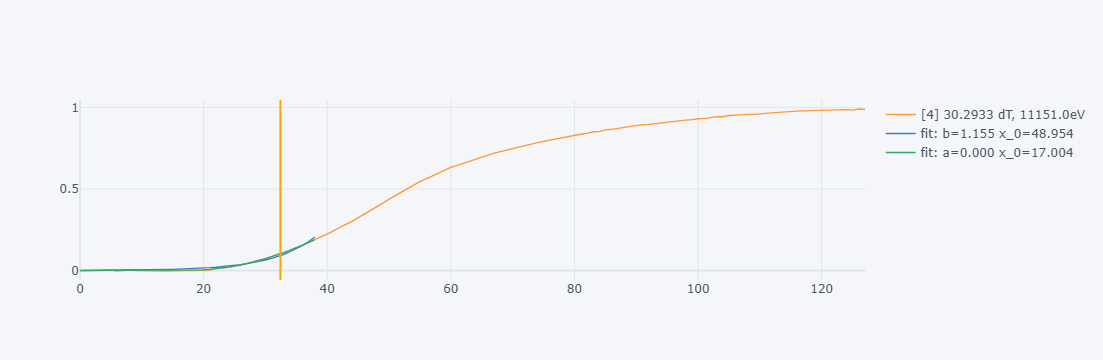

In [108]:
waveform = [4]
wave_df, imap = get_waveforms(waveform, source_data=data0, get_indices_map=True)

part = wave_df[wave_df[imap[waveform[0]]] <= 0.2][imap[waveform[0]]]
x_data = np.arange(0,len(part))
y_data = part
b_exp = lambda x, b, x_0: b**(x-x_0)
c_par = lambda x, a, x_0: a * (max(x - x_0,0))**2
c_par_arr = lambda x, a, x_0: np.array([c_par(x_,a,x_0) for x_ in x])

# Exp fit
popt, pcov = curve_fit(b_exp, x_data, y_data, bounds=([0.1, -10], [10, 70]))
print(popt, pcov)
wave_df['fit: b=%5.3f x_0=%5.3f' % tuple(popt)] = np.nan
wave_df['fit: b=%5.3f x_0=%5.3f' % tuple(popt)].iloc[:len(part)] = b_exp(x_data, *popt)

# Parabola fit
popt, pcov = curve_fit(c_par_arr, x_data, y_data, bounds=([-3, -10], [3, 40]))
print(popt)
wave_df['fit: a=%5.3f x_0=%5.3f' % tuple(popt)] = np.nan
wave_df['fit: a=%5.3f x_0=%5.3f' % tuple(popt)].iloc[:len(part)] = c_par_arr(x_data, *popt)

# wave_df['manual fit'] = b_exp(np.arange(0,len(wave_df)), 1.17, 47)
fig2 = wave_df.iplot(asFigure=True)
fig2.add_vline(x=(160-float([s[s.find("]")+1:s.find("dT")] for s in [col_for_str(wave_df, str(waveform)).replace(" ","")]][0]))/4, line_color="orange")

In [109]:
# display(data0) # 18662 rows
new_max_col = 255
df = get_waveforms(0,255, source_data=data0)
df_new, df_results = df_with_fits(df, 0.2, return_results=True, force_max_col=new_max_col)

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.perf_counter()
fit_parabolas(df, 0.2, force_max_col=new_max_col)
end = time.perf_counter()
print("Elapsed (with compilation) = {}s".format((end - start)))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.perf_counter()
fit_parabolas(df, 0.2, force_max_col=new_max_col)
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

start = time.perf_counter()
recalc_low_acc_results = fit_parabolas(df[[col for col in df.columns if sum([i in col for i in df_results[df_results["rel_x0_cutoff_var"] > 0.00002].index]) > 0]], 0.1)
end = time.perf_counter()
print("Elapsed for recalculating inaccurate ones (after compilation) = {}s".format((end - start)))

Elapsed (with compilation) = 0.7024101999122649s
Elapsed (after compilation) = 0.6964876999845728s
Elapsed for recalculating inaccurate ones (after compilation) = 0.15002960001584142s


,a,x0,x_cutoff,var,x0_cutoff_var,rel_var,rel_x0_cutoff_var,xT,yT_fit
[105],0.001132,18.477737,32,0.000041,0.000028,0.000001,0.000002,32.878250,0.234833
[141],0.000558,18.133794,38,0.000354,0.000294,0.000009,0.000015,41.408037,0.302182


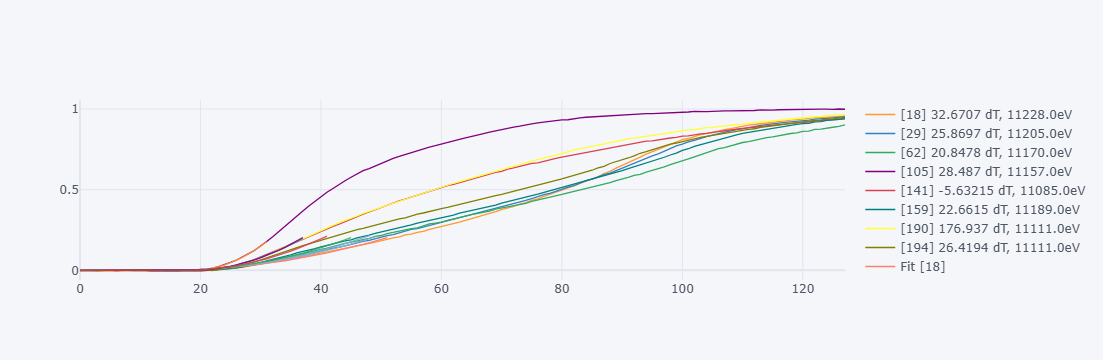

df_results: [-5540.33940281    17.7894721 ] [[ 9.24778230e+05 -2.77510589e+02]
 [-2.77510589e+02  1.15377093e-01]] 
x0,y0 - x1,y1: (0, 17.789472099654702) (0.001, 12.249132696844809)


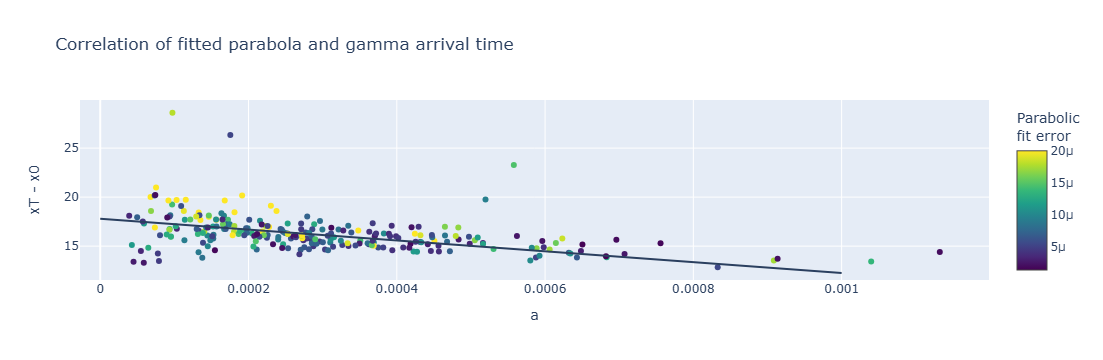

updated_results: [-4786.0578328     17.29651937] [[ 9.08963899e+05 -2.82023166e+02]
 [-2.82023166e+02  1.19536369e-01]] 
x0,y0 - x1,y1: (0, 17.296519373852203) (0.001, 12.510461541048617)


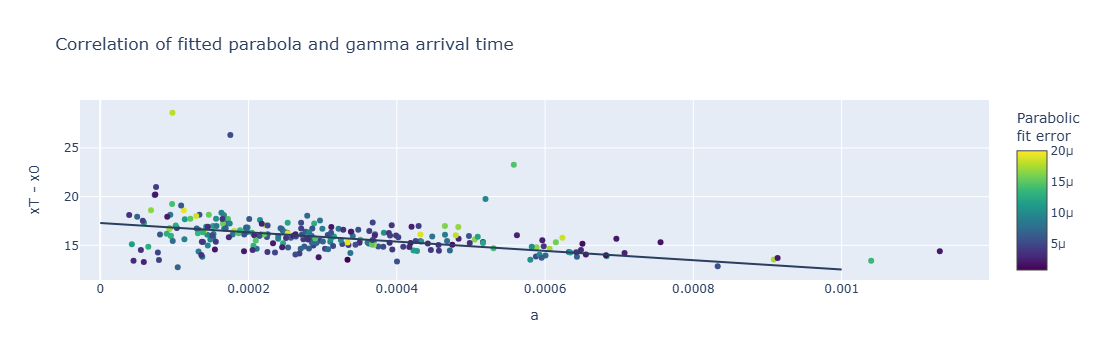

In [110]:
from plotly import graph_objects as go

low_acc_results = df_results[df_results["rel_x0_cutoff_var"] > 0.00003]
past_cutoff_results = df_results[df_results["x_cutoff"] < df_results["xT"]]
notable_results = pd.concat([low_acc_results, past_cutoff_results],axis=0)
# Replace the low accuracy results with the new 'recalc_low_acc_results' values
updated_results = pd.concat([df_results[df_results["rel_x0_cutoff_var"] <= 0.00002], recalc_low_acc_results],axis=0)

# display(low_acc_results)
# display(recal_low_acc_results)
display(past_cutoff_results)
df_new[[col for col in df_new.columns if sum([i in col for i in notable_results.index]+["[190]" in col]) >= 1]].iplot()

fig0 = corr_fig(df_results, ["[190]"], (None, 2e-5))
popt0, pcov0 = curve_fit(lambda x, m, b: m*x + b, df_results["a"], df_results["xT"]-df_results["x0"], bounds=([-10000, 1], [10, 20]))
print("df_results:", popt0, pcov0, "\nx0,y0 - x1,y1:", (0,popt0[1]), (0.001, popt0[0]/1000+popt0[1]))
fig0.update_layout(shapes = [{'type': 'line', 'yref': 'y', 'xref': 'x', 'y0': popt0[1], 'y1': popt0[0]/1000+popt0[1], 'x0': 0, 'x1': 0.001}])
fig0.show()

# fig1 = corr_fig(low_acc_results)
# fig1.add_trace(corr_trace(recalc_low_acc_results))
# fig1.show()

fig2 = corr_fig(updated_results, ["[190]"], (None, 2e-5))
popt1, pcov1 = curve_fit(lambda x, m, b: m*x + b, updated_results["a"], updated_results["xT"]-updated_results["x0"], bounds=([-10000, 1], [10, 20]))
print("updated_results:", popt1, pcov1, "\nx0,y0 - x1,y1:", (0,popt1[1]), (0.001, popt1[0]/1000+popt1[1]))
fig2.update_layout(shapes = [{'type': 'line', 'yref': 'y', 'xref': 'x', 'y0': popt1[1], 'y1': popt1[0]/1000+popt1[1], 'x0': 0, 'x1': 0.001}])
fig2.show() #  "line_dash":"dash"


,a,x0,x_cutoff,var,x0_cutoff_var,rel_var,rel_x0_cutoff_var,xT,yT_fit,xT_prd_0,xT_prd_1
[0],0.000623,18.835561,38,0.000448,0.000370,0.000012,0.000019,34.618675,0.155265,33.171817,33.148997
[1],0.000424,18.100949,41,0.000770,0.000671,0.000019,0.000029,34.354975,0.112114,33.539295,33.366433
[2],0.000172,14.618049,50,0.000613,0.000520,0.000012,0.000014,32.309025,0.053926,31.452906,31.089918
[3],0.000497,17.836202,39,0.000154,0.000130,0.000004,0.000006,33.805000,0.126822,32.870255,32.752435
[4],0.000432,17.003513,39,0.000131,0.000085,0.000003,0.000004,32.426675,0.102703,32.400925,32.233636
...,...,...,...,...,...,...,...,...,...,...,...
[250],0.000269,16.967467,45,0.000404,0.000271,0.000009,0.000009,31.136575,0.053935,33.268518,32.978204
[251],0.000163,14.041218,50,0.000721,0.000685,0.000014,0.000019,32.387800,0.055021,30.925058,30.555401
[252],0.000253,16.659254,45,0.000176,0.000123,0.000004,0.000004,32.904025,0.066760,33.047111,32.744979
[253],0.000367,16.419860,40,0.000131,0.000050,0.000003,0.000002,31.973150,0.088899,32.173277,31.957520


Variance: 2.6222194982758835


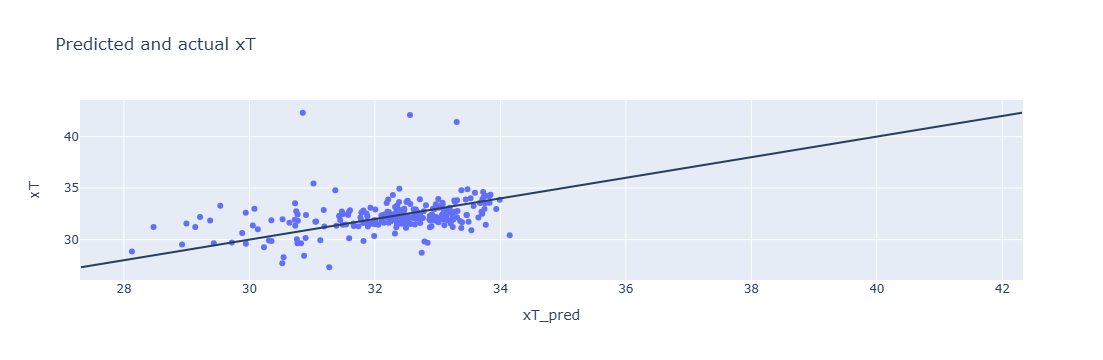

Variance: 2.622860464201522


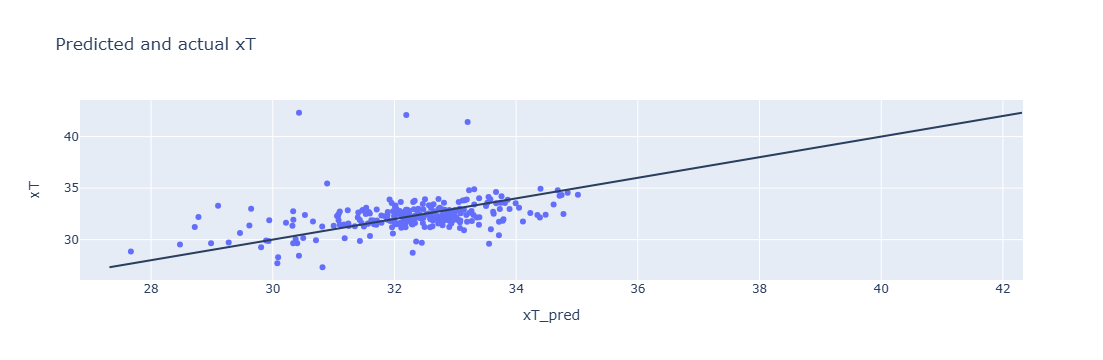

In [131]:
import plotly.express as px
from typing import Callable

display(df_results)
px.scatter(df_results[["xT_prd_0", "xT"]])

def get_pred_func(results_df: pd.DataFrame, drop_rows: list = [], bounds=([-10000, 1], [10, 20])):
    df = results_df.drop(index=drop_rows)
    popt, pcov = curve_fit(lambda x, m, b: m*x + b, df["a"], df["xT"]-df["x0"], bounds=bounds)
    # print("updated_results:", popt, pcov, "\nx0,y0 - x1,y1:", (0,popt[1]), (0.001, popt[0]/1000+popt[1]))
    pred_func = lambda a, x0: popt[0] * a + popt[1] + x0
    return pred_func
    
def pred_trace(results_df: pd.DataFrame, drop_rows: list = [], pred_func: Callable = None, return_variance: bool= False):
    if pred_func is None:
        raise ValueError("Prediction function must be defined")
    df = results_df.drop(index=drop_rows)
    df["xT_pred"] = pred_func(df["a"], df["x0"])
    variance = ((df["xT_pred"] - df["xT"])*(df["xT_pred"] - df["xT"])).sum() / len(df)
    trace = go.Scatter(x=df["xT_pred"],
                       y=df["xT"],
                       mode='markers',
                       # customdata=results_df[["rel_x0_cutoff_var","x_cutoff","xT"]],
                       hovertemplate = '<i>%{text}</i><br>'+
                                      '<b>xT_pred</b>: %{x:.6f}<br>'+
                                      '<b>xT</b>: %{y:.6f}',
                       text = ['Waveform {}'.format(tracename) for tracename in df.index])
    if return_variance:
        return trace, variance
    return trace

def pred_fig(results_df: pd.DataFrame, drop_rows: list = [], pred_func: Callable = None):
    trace, var = pred_trace(results_df, drop_rows, pred_func, return_variance=True)
    fig = go.Figure(data=trace)
    df = results_df.drop(index=drop_rows)
    min_,max_ = df["xT"].min(),df["xT"].max()
    fig.update_layout(title='Predicted and actual xT',
                      xaxis_title="xT_pred",
                      yaxis_title="xT",
                      shapes = [{'type': 'line', 'yref': 'y', 'xref': 'x', 'y0': min_, 'y1': max_, 'x0': min_, 'x1': max_}])
    print("Variance:", var)
    return fig
# updated_results or df_results
pred_fig(df_results, ["[190]"], get_pred_func(df_results, ["[190]"])).show()
pred_fig(updated_results, ["[190]"], get_pred_func(updated_results, ["[190]"])).show()

In [ ]:
import matplotlib as mpl

# def func(t, B, v, t_0):
#     return logistic_function(x/127, a, b, c) #a * np.exp(-b * x) + 1

xdata = np.linspace(0, 128, 50)
y = func(xdata, 5, 0.001, -0.85)
rng = np.random.default_rng()
y_noise = 0.1 * rng.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data with noise')
plt.plot(xdata, y, 'r-', label='data')
# popt, pcov = curve_fit(func, xdata, ydata)
# popt
# plt.plot(xdata, func(xdata, *popt), 'r-',
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(logfunc_127, xdata, ydata, bounds=(0, [10., 1., 0.5]))
print(popt, pcov)
popt
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.7f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()